In [1]:
## General libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import collections
import math
import pprint
import pickle

## My libraries 
import comms

In [2]:
## Optimization Settings  
counts_alg = "A"
genbatch_alg = "A"
batch_size = 32
embedding_size = 32
num_sampled = 16
num_iter = 50000

** Load and format data to sessions and make test and train set **

In [28]:
date_bags_train, word_bags_train, context_ids_train = pickle.load( open( "train_sessions.pkl", "rb" ) )
date_bags_test, word_bags_test, context_ids_test = pickle.load( open( "test_sessions.pkl", "rb" ) )

In [29]:
bots = ["0412468358e09411dfbabeed26fce809", "d0ef1e7d53b869c477dbbd4ec6cbc46d"]
word_bags_train = [wbt for wbt,ctx in zip(word_bags_train, context_ids_train) if ctx not in bots]

** Generate data for training the model **

In [5]:
## 1) context == all data of one user 
word_bags_all_per_user = [[w for wb in word_bag for w in wb] for word_bag in word_bags_train] ## np.sum(np.array([len(w)<2 for w in word_bags_all_per_user]))

## 2) context = one user session 
word_bags_all_per_sess = [wb for word_bag in word_bags_train for wb in word_bag]
word_bags_all_per_sess = [wb for wb in word_bags_all_per_sess if len(wb) >= 2] ## np.sum(np.array([len(x)<2 for x in word_bags_all_per_sess]))

In [6]:
# flat_wb_tr = [[w for wb in word_bag for w in wb] for word_bag in word_bags_train]
# flat_wb_ts = [[w for wb in word_bag for w in wb] for word_bag in word_bags_test]
# sharp_wb = flat_wb_tr
# sharp_wb.extend(flat_wb_ts)

** Dict and batch gen **

In [7]:
# dictionary, reversed_dictionary = comms.create_dictionary(flat_wb_tr, counts_alg)

# ## Number of distinct words in vocabulary
# vocabulary_size = len(dictionary)

# genbatch_prereq = comms.create_genbatch_prerequisities(flat_wb_tr, dictionary)

# def generate_batch(batch_size): 
#     return comms.generate_batch(batch_size, genbatch_prereq, genbatch_alg) 

In [8]:
dictionary, reversed_dictionary = comms.create_dictionary(word_bags_all_per_sess, counts_alg)

## Number of distinct words in vocabulary
vocabulary_size = len(dictionary)

genbatch_prereq = comms.create_genbatch_prerequisities(word_bags_all_per_sess, dictionary)

def generate_batch(batch_size): 
    return comms.generate_batch(batch_size, genbatch_prereq, genbatch_alg) 

** Build model and train the shit out of it **

In [9]:
w2v_model = comms.create_w2v_tf_model(batch_size, embedding_size, vocabulary_size, num_sampled, learn_rate = 1.0)
train_inputs, train_labels, embeddings, nce_weights, nce_biases, loss, optimizer, init = w2v_model

In [10]:
sess = tf.Session()
sess.run(init)

In [11]:
## Learn the embeddings
for i in range(num_iter): 
    batch, labels = generate_batch(batch_size)
    _, loss_eval = sess.run([optimizer, loss], {train_inputs : batch, train_labels : labels})
    if i % 1000 == 0: 
        print("Loss at iteration",i, " : ",loss_eval)

Loss at iteration 0  :  57.7861
Loss at iteration 1000  :  4.38639
Loss at iteration 2000  :  3.61576
Loss at iteration 3000  :  2.98305
Loss at iteration 4000  :  3.41891
Loss at iteration 5000  :  2.58944
Loss at iteration 6000  :  2.10728
Loss at iteration 7000  :  2.08146
Loss at iteration 8000  :  1.63583
Loss at iteration 9000  :  2.02638
Loss at iteration 10000  :  1.73083
Loss at iteration 11000  :  2.44267
Loss at iteration 12000  :  1.57905
Loss at iteration 13000  :  1.25207
Loss at iteration 14000  :  1.58706
Loss at iteration 15000  :  1.68757
Loss at iteration 16000  :  1.89855
Loss at iteration 17000  :  1.50063
Loss at iteration 18000  :  1.22871
Loss at iteration 19000  :  1.62815
Loss at iteration 20000  :  2.04751
Loss at iteration 21000  :  1.51324
Loss at iteration 22000  :  2.16603
Loss at iteration 23000  :  1.15286
Loss at iteration 24000  :  0.997216
Loss at iteration 25000  :  1.48186
Loss at iteration 26000  :  1.64441
Loss at iteration 27000  :  1.50004
Loss

In [12]:
embeddings_eval, nce_weights_eval, nce_biases_eval = sess.run([embeddings, nce_weights, nce_biases]) 

In [13]:
model_packed = embeddings_eval, nce_weights_eval, nce_biases_eval, dictionary, reversed_dictionary
pickle.dump(model_packed, open("model_packed.pkl", "wb"))

** Test that shit **

** Eval whole user history **

In [14]:
wb_two_sess = [wb for wb in word_bags_test if len(wb)>=2]
wb_test_flat = [[w for wb in word_bag for w in wb] for word_bag in word_bags_test]  ## np.sum(np.array([len(x)<2 for x in wb_test_flat])) 

In [15]:
def pred_order(ind_list):
    """
    Order in which we will present item i to the user 
    
    Arguments:
    ind_list -- indices of items according to dictionary
    
    Return:
    order_presented -- vector of shape (embeddings.shape[0], ), ith entry is order in which we present ith item
    """
    mean_emb = np.mean(embeddings_eval[ind_list,:], axis=0)
    preferences = comms.softmax(np.sum(nce_weights_eval * mean_emb, axis=1) + nce_biases_eval)
    order_presented = len(preferences) - np.argsort(np.argsort(preferences)) 
    return order_presented

In [16]:
def eval_one_sess(sess, naive=False): 
    """
    sess -- list of item ids
    naive -- use naive approach for defining order, we present items that were already selected
             returns order 1 if predicted item is in past items
             returns 1000 if predicted item is not in past items
    
    """
    ind = [dictionary.get(s) for s in sess]
    ind = [i for i in ind if i != None]
    if len(ind) == 0:
        return []
    else: 
        sess_orders = []
        for j in range(1, len(ind)-1):
            if naive: 
                sess_orders.append(1 if ind[j] in ind[0:j] else 1000)
            else:
                sess_orders.append(pred_order(ind[0:j])[ind[j]])
#                 sess_orders.append(list(np.random.choice(2007,2007, replace=False))[ind[j]]) ## stupid approach 

    return sess_orders

In [17]:
nai = False
evals_for_flat_users = [eval_one_sess(s, naive=nai) for s in wb_test_flat]
print("Number of testing users: ", len(evals_for_flat_users))
print("Number of testing users, where prediction available:", np.sum(np.array([len(x) > 0 for x in evals_for_flat_users])))
median_evals_for_flat_users = [np.median(e) for e in evals_for_flat_users if len(e) > 0]
percentile_evals_for_flat_users = [np.percentile(e,90) for e in evals_for_flat_users if len(e) > 0]
print("Number of users that had more than half of their predictions on first page: ", np.sum(np.array([e <= 48 for e in median_evals_for_flat_users])))
print("Number of users that had more than 90% of their predictions on first page: ", np.sum(np.array([e <= 48 for e in percentile_evals_for_flat_users])))

Number of testing users:  500
Number of testing users, where prediction available: 284
Number of users that had more than half of their predictions on first page:  222
Number of users that had more than 90% of their predictions on first page:  187


In [18]:
## Procento produktu co se zobrazi uzivateli na prvni strance 
np.mean([np.mean([e<48 for e in eval]) for eval in evals_for_flat_users if len(eval)>0])

0.76553923122297618

In [19]:
import matplotlib.pyplot as plt

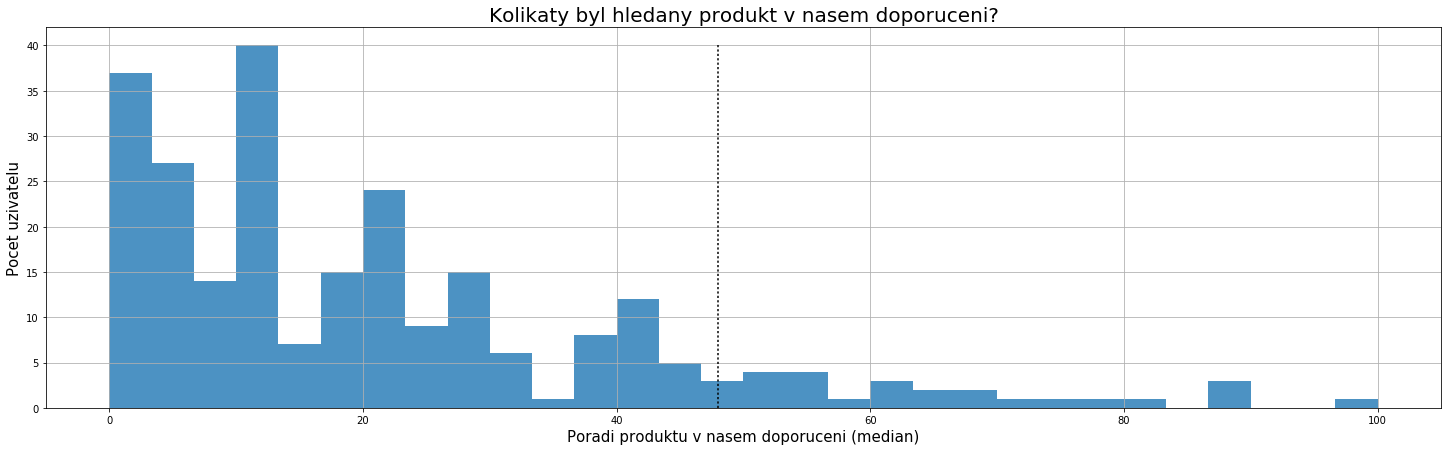

In [20]:
plt.figure(figsize=(25,7))
plt.hist(median_evals_for_flat_users, range=[0,100], alpha=0.8, bins=30)
plt.title("Kolikaty byl hledany produkt v nasem doporuceni?", size = 20)
plt.xlabel("Poradi produktu v nasem doporuceni (median)", size= 15)
plt.ylabel("Pocet uzivatelu", size = 15)
plt.vlines(x=48, ymin=0, ymax=40, linestyles="dotted")
plt.grid()
plt.show()

** Eval new session **

In [ ]:
predictive_sess = [[dictionary.get(w) for ww in wb[:-1] for w in ww] for wb in wb_two_sess]
target_sess = [[dictionary.get(x) for x in wb[-1]] for wb in wb_two_sess]

In [ ]:
target_sess

In [ ]:
next_sess_predictions = [list(pred_order(predictive_sess[i])[target_sess[i]]) for i in range(len(predictive_sess))]

In [ ]:
## naivni pristup 
next_sess_predictions = [ np.mean([1 if t in ps else 0 for t in trg]) for trg, ps in zip(target_sess, predictive_sess) ]

In [ ]:
np.mean(next_sess_predictions)

In [ ]:
np.mean([np.mean([x <= 48 for x in wb]) for wb in next_sess_predictions])

** Eval EACH session **

In [ ]:
wb_two_sess = [wb for wb in word_bags_test if len(wb)>=2]
wb_two_sess = [[w for w in word_bag if len(w)>1] for word_bag in wb_two_sess]
wb_two_sess = [wb for wb in wb_two_sess if len(wb)>0]
wb_two_flat = [w for wb in wb_two_sess for w in wb]
wb_two_its = [[dictionary.get(w) for w in wb] for wb in wb_two_flat] 
wb_two_its = [[w for w in wb if w!=None] for wb in wb_two_its]

In [ ]:
def eval_one(ind, naive=False): 
    sess_orders = []
    for j in range(1, len(ind)):
        if naive: 
            sess_orders.append(1 if ind[j] in ind[0:j] else 1000)
        else:
            sess_orders.append(pred_order(ind[0:j])[ind[j]])
    return sess_orders

In [ ]:
wb_two_ords = [eval_one(w) for w in wb_two_its]

In [ ]:
np.sum(np.array([np.median(w)<=48 for w in wb_two_ords])) / len(wb_two_ords)